In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lsda.mcs import *
from lsda.nn import *
from lsda.score import *
from lsda.utils import *

import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Generate data

In [3]:
# Initialize data
size = 64
kolmogorov = KolmogorovFlow(size=size, dt=0.2)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Generate data
# TODO: save each as one file

n_data = 1024
length = 128
all_x = list()

for n in tqdm(range(n_data)):
    x = kolmogorov.prior()
    x = kolmogorov.trajectory(x, length=length)
    x = x[length//2:]
    all_x.append(x)
    
x = torch.stack(all_x)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [20:30<00:00,  1.20s/it]


In [5]:
# Split data
i = int(0.8 * len(x))
j = int(0.9 * len(x))

train_x= x[:i]
val_x= x[i:j]
test_x= x[j:]

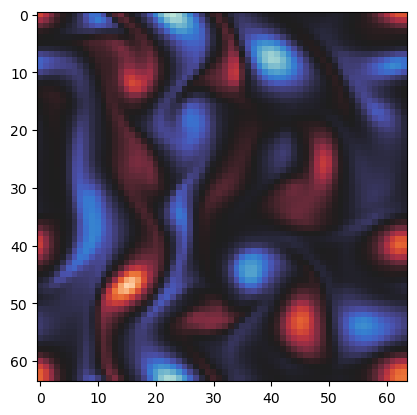

In [6]:
# Visualize testing data
w = kolmogorov.vorticity(test_x)
sample_id = 0
timestep = 0

f, ax = plt.subplots()
ax.imshow(w[sample_id, timestep], cmap=sns.cm.icefire)

### Train encoder-decoder

In [7]:
# Dataset construction
input_size = 2
hidden_size = 2
batch_size = 64
window = 1

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [8]:
# Define hyperparameters
epochs = 256
learning_rate = 1e-2
weight_decay = 1e-3

# Initialize model and optimizer
latent = ConvEncoderDecoder(window*input_size, hidden_size, window*input_size, window).to(device)
optimizer = torch.optim.AdamW(latent.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    latent.train()

    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
    
        z = latent.encoder(x)
        x_ = latent.decoder(z)
        l = (x_ - x).square().mean()
        l.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        losses_train.append(l.detach())

    ## Valid
    latent.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            
            z = latent.encoder(x)
            x_ = latent.decoder(z)
            l = (x_ - x).square().mean()
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [03:08<00:00,  1.36it/s]


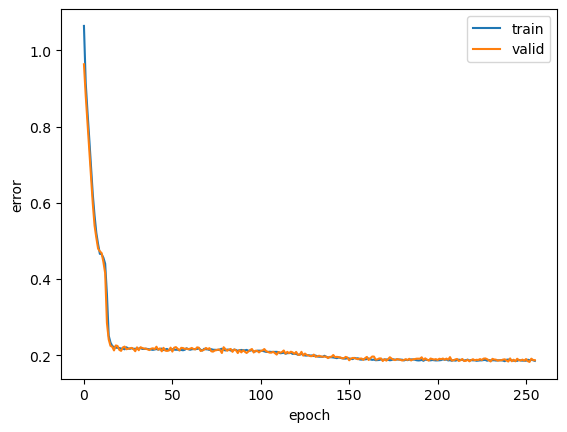

In [9]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Train diffusion model

In [10]:
# Latent dataset creation
input_size = 3
batch_size = 64
window = 5
order = window // 2
embedding = 64
hidden_channels = (96, 192, 384)
hidden_blocks = (3, 3, 3)
kernel_size = 3

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [11]:
# Network
score = MCScoreNet(2, order=window // 2)
score.kernel = LocalScoreUNet(
        channels=window * 2,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=2,
        padding_mode='circular',
    )

sde = VPSDE(score.kernel, shape=(window * 2, 64, 64)).to(device)


In [12]:
# diffusion
x, kwargs = next(iter(trainloader))
x = x.to(device)
sde.loss(x, **kwargs)

tensor(1.1374, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
# Defining hyperparemeters
epochs = 128
learning_rate = 2e-4
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(sde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    sde.train()
    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
        
        # compute noise differential loss
        l = sde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    sde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            l = sde.loss(x, **kwargs)
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

    ## Step
    scheduler.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [37:39<00:00, 17.65s/it]


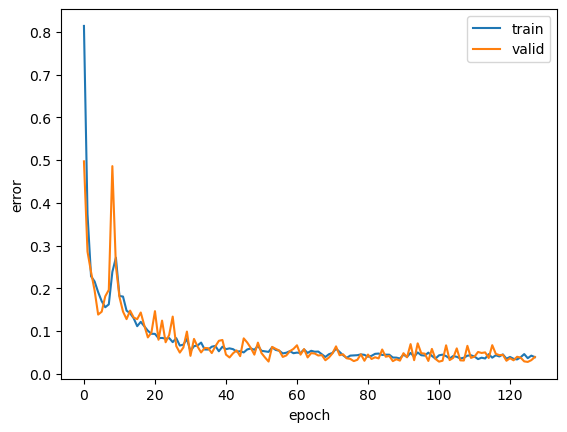

In [14]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Train latent diffusion model

In [15]:
# Latent dataset creation
input_size = hidden_size
l_size = size // 2
batch_size = 64
window = 5
order = window // 2

train_z = latent.encoder(train_x.view(-1, 2, size, size).to(device)).detach().cpu().reshape(-1, length // 2, hidden_size, l_size, l_size)
val_z = latent.encoder(val_x.view(-1, 2, size, size).to(device)).detach().cpu().reshape(-1, length // 2, hidden_size, l_size, l_size)
test_z = latent.encoder(test_x.view(-1, 2, size, size).to(device)).detach().cpu().reshape(-1, length // 2, hidden_size, l_size, l_size)

trainset = TrajectoryDataset(train_z, window=window, flatten=True)
validset = TrajectoryDataset(val_z , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [16]:
# Network
score_latent = MCScoreNet(input_size, order=window // 2)
score_latent.kernel = LocalScoreUNet(
        channels=window * input_size,
        size=l_size,
        embedding=embedding,
        hidden_channels=hidden_channels,
        hidden_blocks=hidden_blocks,
        kernel_size=kernel_size,
        activation=torch.nn.SiLU,
        spatial=input_size,
        padding_mode='circular',
    )

lsde = VPSDE(score_latent.kernel, shape=(window * input_size, l_size, l_size)).to(device)


In [17]:
# latent diffusion
x, kwargs = next(iter(trainloader))
x = x.to(device)
lsde.loss(x, **kwargs)

tensor(1.5976, device='cuda:0', grad_fn=<MeanBackward0>)

In [18]:
# Defining hyperparameters
epochs = 128
learning_rate = 2e-4
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(lsde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    lsde.train()
    for batch in trainloader:
        x, kwargs = batch
        x = x.to(device)
        
        # compute noise differential loss
        l = lsde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    lsde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            x = x.to(device)
            
            l = lsde.loss(x, **kwargs)
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

    ## Step
    scheduler.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [11:11<00:00,  5.24s/it]


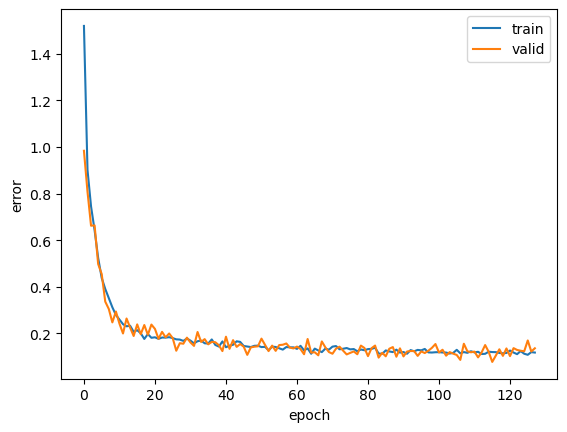

In [19]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Evaluation

Generate low frequency observations for assimilation (in latent space)

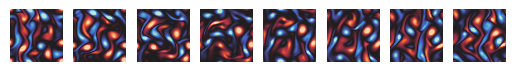

In [20]:
true_x, true_z = test_x[0, :29], test_z[0, :29]
w = kolmogorov.vorticity(true_x[::4])

# Plot true
f, ax = plt.subplots(1, len(w))
for N in range(w.shape[0]):
    ax[N].imshow(w[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
    ax[N].axis('off')

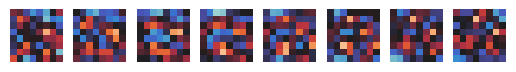

In [21]:
def A(x):
    return kolmogorov.coarsen(x[..., ::4, :, :, :], 8)

sigma_sq = 0.1
y_star = torch.normal(A(true_x), sigma_sq)
yz_star = torch.normal(A(true_z), sigma_sq)

w = kolmogorov.vorticity(y_star) / 2.5
w = kolmogorov.upsample(w, 2, mode='nearest')

# Plot coarsen
f, ax = plt.subplots(1, len(w))
for N in range(w.shape[0]):
    ax[N].imshow(w[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
    ax[N].axis('off')

In [22]:
n_corrections = 1
all_x_sample = []

# Sampling for diffusion model
sde_eval = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=sigma_sq,
        sde=VPSDE(score, shape=()),
    ),
    shape=true_x.shape).to(device)

x = sde_eval.sample(steps=256, corrections=n_corrections, tau=0.5)
x = kolmogorov.vorticity(x[::4])
all_x_sample.append(x)

# Sampling from latent diffusion model
lsde_eval = VPSDE(
    GaussianScore(
        y=yz_star,
        A=A,
        std=sigma_sq,
        sde=VPSDE(score_latent, shape=()),
    ),
    shape=true_z.shape).to(device)

x = lsde_eval.sample(steps=256, corrections=n_corrections, tau=0.5)
x = latent.decoder(x)
x = kolmogorov.vorticity(x[::4])
all_x_sample.append(x)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:18<00:00,  3.26it/s]


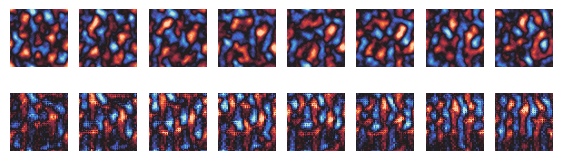

In [23]:
# Plot assimilation
f, ax = plt.subplots(all_x_sample.shape[0], all_x_sample.shape[1], figsize=(7, 2))

for M in range(all_x_sample.shape[0]):
    w = all_x_sample[M]
    w = w.detach().cpu()
    for N in range(w.shape[0]):
        ax[M, N].imshow(w[N], cmap=sns.cm.icefire, vmin=-1, vmax=1)
        ax[M, N].axis('off')